# Lyft Data Challenge

The following notebook is for analyzing and visualizing the data provided by Lyft. Refer to the Lyft Data Challenge Doc for more information. 

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc

## driver_ids.csv
**driver_id** - Unique identifier for a driver  
**driver_onboard_date** - Date on which driver was on-boarded

In [17]:
driver_ids = pd.read_csv("driver_ids.csv")
driver_ids.head()

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 00:00:00
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 00:00:00
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23 00:00:00
4,01674381af7edd264113d4e6ed55ecda,2016-04-29 00:00:00


## ride_ids.csv
**driver_id** - Unique identifier for a driver  
**ride_id** - Unique identifier for a ride that was completed by the driver  
**ride_distance** - Ride distance in **meters**  
**ride_duration** - Ride duration in **seconds**  
**ride_prime_time** - Prime Time -*percentage increase to the fare* - applied on the ride  

In [18]:
ride_ids = pd.read_csv("ride_ids.csv")
ride_ids.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


## ride_timestamps.csv
**ride_id** - Unique identifier for a ride  
**event** - event describes the type of event (see below)  
**timestamp** - Time of event  

**Event Descriptions**  
*requested_at* - passenger requested a ride  
*accepted_at* - driver accepted a passenger request  
*arrived_at* - driver arrived at pickup point  
*picked_up_at* - driver picked up the passenger  
*dropped_off_at* - driver dropped off a passenger at destination  

In [19]:
ride_timestamps = pd.read_csv("ride_timestamps.csv")
ride_timestamps.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


## Overview of the entire data set

Brief overview to better understand the data set. Averages across all drivers and summaries are made of the variables provided. Plots will also be generated to help visualize data and reveal potential outliers. **Refer to the markdown box before each cell to understand what the code is representing**

## Cleaning the data set (big sad)

In [20]:
driver_ids.sort_values("driver_onboard_date", ascending=True, inplace=True) #Sorts the drivers by date joined
driver_ids["driver_onboard_date"] = pd.to_datetime(driver_ids["driver_onboard_date"]) # converts strings to timestamp objects

driver_ids_na = driver_ids[driver_ids["driver_onboard_date"].isnull() | driver_ids["driver_onboard_date"].isnull()]
print(driver_ids_na) # No nan values in ride_ids

ride_ids_na = ride_ids[ride_ids["ride_distance"].isnull() | ride_ids["ride_duration"].isnull() 
                       | ride_ids["ride_prime_time"].isnull() | ride_ids["ride_id"].isnull() | ride_ids["driver_id"].isnull()]
print(ride_ids_na) # No nan values in ride_ids

ride_timestamps.sort_values("timestamp", ascending=True, inplace=True) #ride_timestamps is now sorted by timestamp
ride_timestamps["timestamp"] = pd.to_datetime(ride_timestamps["timestamp"]) # converts strings to timestamp objects

ride_timestamps_na = ride_timestamps[ride_timestamps["timestamp"].isnull() | ride_timestamps["event"].isnull()
                                    | ride_timestamps["ride_id"].isnull()]
print(ride_timestamps_na) # One nan value: Index 434222


Empty DataFrame
Columns: [driver_id, driver_onboard_date]
Index: []
Empty DataFrame
Columns: [driver_id, ride_id, ride_distance, ride_duration, ride_prime_time]
Index: []
                                 ride_id       event timestamp
434222  72f0fa0bd86800e9da5c4dced32c8735  arrived_at       NaT


**NaN value**  
It seems that there is one nan value in the timestamps data set. We will need to do a further inspection by looking at the other events and variables related to the ride_id. 

**TLDR;**  
Lol. So I'm assuming that the drivers and lyft users self-report arrival time and pick up time. So in some instances, the arrival time is later than the pick up time?? I don't think we're going to be using that difference hopefully, but if anyone mentions it, we can talk about human error. One way of doing it is just **removing all the negative differences** and analyze the positive differences. That's what I'm doing. lol. **NOW LOOKING at which drivers are in the rides data set, but not in the driver_id data set and vice versa**

**Other than that, the data is pretty clean (hopefully)**

In [21]:
ride_timestamps_na

,ride_id,event,timestamp
434222,72f0fa0bd86800e9da5c4dced32c8735,arrived_at,NaT


In [22]:
#Let's take a look at the other timestamps with the same ride_id
ride_timestamps[ride_timestamps["ride_id"] == "72f0fa0bd86800e9da5c4dced32c8735"]

,ride_id,event,timestamp
434220,72f0fa0bd86800e9da5c4dced32c8735,requested_at,2016-04-20 11:56:50
434221,72f0fa0bd86800e9da5c4dced32c8735,accepted_at,2016-04-20 11:57:20
434223,72f0fa0bd86800e9da5c4dced32c8735,picked_up_at,2016-04-20 12:02:20
434224,72f0fa0bd86800e9da5c4dced32c8735,dropped_off_at,2016-04-20 12:16:30
434222,72f0fa0bd86800e9da5c4dced32c8735,arrived_at,NaT


It looks like the driver arrived at the pick up spot sometime between 11:57 and 12:02, a 5 minute window frame. We can asses the other rides of the driver to assign an accurate estimate. 

In [23]:
#Let's take a look at the driver's other rides. First we need to find the driver_id associated with the ride_id.
nan_driver_id = ride_ids.query("ride_id == '72f0fa0bd86800e9da5c4dced32c8735'")["driver_id"]

#Look at the rest of the rides associated with this driver.
nan_driver_rides = ride_ids.query("driver_id == '7c1478b12207107ae4296e656a49d6f6'").drop(["ride_distance", 
                                                                                              "ride_duration",
                                                                                              "ride_prime_time"], axis=1)

#We can do a left join with the ride_timestamps to find all the requested_at and accepted_at timestamps of each ride.
nan_rides_timestamps = pd.merge(nan_driver_rides, ride_timestamps, how='left', on='ride_id').query("event == 'arrived_at'" +
                                                                                                  "| event == 'picked_up_at'")

#We can pivot the table and then find the avg time between arrived_at and picked_up time.
nan_rides_timestamps = nan_rides_timestamps.pivot(index="ride_id", columns="event", values="timestamp").sort_values("arrived_at")
nan_rides_timestamps

avg_time = np.mean(nan_rides_timestamps["picked_up_at"] - nan_rides_timestamps["arrived_at"])/np.timedelta64(1,'s')
median_time = np.median(nan_rides_timestamps["picked_up_at"] - nan_rides_timestamps["arrived_at"])/np.timedelta64(1,'s')
print("Average time: " + str(avg_time)) #It seems there is an average time of 2 seconds so we can just plug that value in for the driver
print("Median time: " + str(median_time))
#print((nan_rides_timestamps["picked_up_at"] - nan_rides_timestamps["arrived_at"])/np.timedelta64(1,'s')) #wtf why is there a -237

print(nan_rides_timestamps.loc["6aca1ea59fbacd2964a79a05271b76a3", :])
ride_timestamps.query("ride_id == '6aca1ea59fbacd2964a79a05271b76a3'")

Average time: -2.145454545
Median time: 2.0
event
arrived_at     2016-04-13 13:08:21
picked_up_at   2016-04-13 13:04:24
Name: 6aca1ea59fbacd2964a79a05271b76a3, dtype: datetime64[ns]


,ride_id,event,timestamp
403105,6aca1ea59fbacd2964a79a05271b76a3,requested_at,2016-04-13 12:56:04
403106,6aca1ea59fbacd2964a79a05271b76a3,accepted_at,2016-04-13 12:56:10
403108,6aca1ea59fbacd2964a79a05271b76a3,picked_up_at,2016-04-13 13:04:24
403107,6aca1ea59fbacd2964a79a05271b76a3,arrived_at,2016-04-13 13:08:21
403109,6aca1ea59fbacd2964a79a05271b76a3,dropped_off_at,2016-04-13 13:14:30


831.0
-3476.0


/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


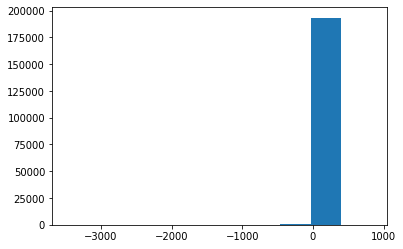

Index(['0001480a2c27492b1f8cb5fbc38ca667', '0004a3db0fb83d99007c394173660ac3',
       '000c670907b0568169841eed62528880', '0018c1ba44e0d4342e938a53073cbd10',
       '0022fe374e96506147a39575ac525165', '0024ec68edefcde7f253b581fa28dfc3',
       '00367dd7bfe892a2d753b859fcaa5c5c', '003945026d2b50d879c69b739276e50d',
       '004e9f1508ec18da15408b99e832bb8b', '00607b911f1f974ea38c3eb292912fe4',
       ...
       'ffc4c71a02f252cf490430ab64d319a0', 'ffd296479e0437be32a47fef7cc298b3',
       'ffd5e27e1e9d50fa8c6da6a93ebe7e38', 'ffd7f5f887a9a9b312e2f75eb8e1edcc',
       'ffd852fddf76b03f8cd16ab9f421fabd', 'ffda480d975b1da422a6334b5c12fc97',
       'ffedbc5cdb39d85df13305380d773317', 'fff413861e9fde9fd294d9313cfc949c',
       'fff672ec0d550e787cdb6e87cfc61e4a', 'fffe87c305afa41349e56f63731e04ea'],
      dtype='object', name='ride_id', length=8496)

In [24]:
# Okay, why are there negative arrived and picked up at wtf.
pivot_timestamps = ride_timestamps.pivot(index="ride_id", columns="event", values="timestamp")
pivot_timestamps.query("picked_up_at < arrived_at")
diff = (pivot_timestamps["picked_up_at"] - pivot_timestamps["arrived_at"])/np.timedelta64(1,'s')
print(max(diff))
print(min(diff))
plt.hist(diff)
plt.show()

#TBH we can probably remove the negative differences from the data set since the proportion of positive differences are greater
tf = pivot_timestamps.query("picked_up_at < arrived_at").index
tf

In [25]:
ride_timestamps_clean = ride_timestamps.set_index("ride_id").drop(tf, axis=0)
ride_timestamps_clean.head()
print(ride_timestamps.shape[0])
print(ride_timestamps_clean.shape[0])
print((ride_timestamps.shape[0] - ride_timestamps_clean.shape[0])/len(tf)) ## Checking that ride_timestamps_clean is actually clean
ride_timestamps_clean.head()

970405
927925
5.0


,event,timestamp
ride_id,,
655ccbeb2a62880159e20e986c1cdaeb,requested_at,2016-03-28 05:48:18
655ccbeb2a62880159e20e986c1cdaeb,accepted_at,2016-03-28 05:48:23
655ccbeb2a62880159e20e986c1cdaeb,arrived_at,2016-03-28 06:02:36
655ccbeb2a62880159e20e986c1cdaeb,picked_up_at,2016-03-28 06:02:39
655ccbeb2a62880159e20e986c1cdaeb,dropped_off_at,2016-03-28 06:37:51


## Important
**As of this cell, ride_timestamps_clean is cleaned from all glitchy arrival times. If you want to use arrival times or pick up times as a variable, please refer to ride_timestamps_clean**

## Important

**It was discovered that not all drivers in the rides data set are recorded on the drivers data set. rip. back to cleaning. **

In [26]:
rides_drivers_id = pd.merge(ride_ids, driver_ids, how="left", on="driver_id")
missing_driver_id = rides_drivers_id.query("driver_onboard_date != driver_onboard_date")
missing_drivers = missing_driver_id["driver_id"].unique()
print(missing_drivers)
print(len(missing_drivers)) ## we have 83 drivers that were never recorded in the onboard date. 
## Is it because they started after May?

['056175954c78be4c4de7e80167b7e1f9' '0d993c2eba3d9dd2e60ecc8814618931'
 '0ed6cac7a3e2f1b324f50086f288bcfc' '0ef7e21012a26a8f3678f02c211488ae'
 '110484e77a78d2e441af9a01a7bf4ce6' '17c09e7e39d8ab4bb4e035061d43ecdd'
 '17dd3e3b2551857d6cc8ff106936676d' '182a0089c24f844efcc4daa5a21eb895'
 '182c1429cf5b585424fe676a632836df' '190abbe65af2b77794e0a6beb37cc613'
 '1b3e75000525f6231606ba9fc755fecc' '1bcc1e136b0515da625e163be33bbc48'
 '1bcf1520b0837676f006825880b133a9' '1d4f979b3f0dda07f55d459c4b69a258'
 '1d5bb1726114e5b950619517a6dd81c3' '1e581fdbb43900bf8d366cc0ed33ba47'
 '208b04693b8a9ef849d894070537aa79' '211e4df57e1657e4b97c9dabf2f99697'
 '234bb57cea53cfb13d8faf4a2900341a' '2486ffe6e7e21083d3e7fcf38907c0b4'
 '2715aa38740fc559be08fd54dccd1803' '2c985e2b039f99a0eaf86c50a7b1af42'
 '2ceb9ff7898dccb3e0a77ea559c6b2f2' '2fc2b91e6f4452b5a6957a1a79316c07'
 '30ba26d095b10a14a5914e247b07e82d' '310d41d776c490d00a0845be9b1920c6'
 '360986407495af6c54b95e399891890c' '364c929f1d6535aa17df83ebcb349e87'
 '383f

In [27]:
# Is this the same the other way around? Are there drivers who have never done a Lyft ride?
drivers_rides_id = pd.merge(driver_ids, ride_ids, how="left", on="driver_id")
missing_driver_id2 = drivers_rides_id.query("ride_duration != ride_duration")
missing_driver_id2 ## Seems like these drivers never had rides???

,driver_id,driver_onboard_date,ride_id,ride_distance,ride_duration,ride_prime_time
408,1e9b964b3e3d0289794289579269247a,2016-03-28,NaN,NaN,NaN,NaN
14246,4856b892095f3afe8607a5ba0121b7b8,2016-03-30,NaN,NaN,NaN,NaN
16789,74279b827e47bbddb5ba57863c174995,2016-03-30,NaN,NaN,NaN,NaN
18644,e761f3e1d225c421222cfe150072ad3c,2016-03-31,NaN,NaN,NaN,NaN
20763,94d5f7697a40886a8723f6015fe47841,2016-03-31,NaN,NaN,NaN,NaN
21265,339a64370e18200c78fa15487f688c74,2016-03-31,NaN,NaN,NaN,NaN
24461,39b23365604d2633d74192b7131d6f67,2016-04-01,NaN,NaN,NaN,NaN
27065,da582077a9e547fc6e24b8d100e64209,2016-04-01,NaN,NaN,NaN,NaN
29054,5785f300b54051f8791ab00c424416a3,2016-04-03,NaN,NaN,NaN,NaN
43032,ad6489ea30a7952d7f3ec6277553fc4f,2016-04-05,NaN,NaN,NaN,NaN


It seems like 83 drivers don't have recorded rides in the ride_ids dataset. lol. Going to remove them because it seems pretty random.

In [28]:
driver_ids_clean = driver_ids.set_index("driver_id").drop(missing_driver_id2["driver_id"])
print(driver_ids.shape[0])
print(driver_ids_clean.shape[0])

937
854


**FROM THIS POINT ON, DRIVER_IDS_CLEAN DOES NOT CONTAIN THOSE 83 DRIVERS WHO HAVE NEVER HAD A RECORDED RIDE**

In [29]:
# Merging ride_timestamps with the missing_drivers.
missing_driver_id_timestamps = pd.merge(missing_driver_id, ride_timestamps, how="left", on="ride_id")
missing_driver_timestamps = missing_driver_id_timestamps.groupby("driver_id").count().query("event > 0") ## These drivers have timestamps. 
# Let's see their earliest recorded ride. If it's after 5/15 maybe we can assume they didn't join Lyft until after.
missing_driver_id_timestamps.set_index("driver_id").loc[missing_driver_timestamps.index, :].query("event == 'accepted_at'")

,ride_id,ride_distance,ride_duration,ride_prime_time,driver_onboard_date,event,timestamp
driver_id,,,,,,,
17c09e7e39d8ab4bb4e035061d43ecdd,12411d838432ee6e241c27c967771c61,1759,368,0,NaT,accepted_at,2016-04-07 09:15:14
17c09e7e39d8ab4bb4e035061d43ecdd,12630ef08d7c2756b2e91fa47386c57b,8107,2246,0,NaT,accepted_at,2016-04-07 18:27:04
17c09e7e39d8ab4bb4e035061d43ecdd,1517b81624601a17b64ba499e28679c7,5595,787,0,NaT,accepted_at,2016-04-08 17:26:17
17c09e7e39d8ab4bb4e035061d43ecdd,16c277fb6a211556218597e5a7e9bda3,1630,305,0,NaT,accepted_at,2016-04-09 11:15:44
17c09e7e39d8ab4bb4e035061d43ecdd,190d4cb36852111ca26ffa0c035f21bd,1653,284,25,NaT,accepted_at,2016-04-21 16:51:36
17c09e7e39d8ab4bb4e035061d43ecdd,1a936c699258738e1c1a84b7fbed4091,22706,1208,0,NaT,accepted_at,2016-04-11 13:28:52
17c09e7e39d8ab4bb4e035061d43ecdd,1b7f7d78bf538cc434b5989e165742c7,4287,1111,50,NaT,accepted_at,2016-04-20 19:10:05
17c09e7e39d8ab4bb4e035061d43ecdd,1f6add0095f4b015ab94a6f50e8d272e,1138,322,75,NaT,accepted_at,2016-04-20 19:00:20
17c09e7e39d8ab4bb4e035061d43ecdd,25e6d4f4a0b88145a405c92637f7b121,4162,673,0,NaT,accepted_at,2016-04-09 18:19:41


## The sample population and its statistics

In the following lines of code, we will explore some of the statistics of the Lyft Drivers as a whole. How many drivers are represented in the data set? How many total rides are there? What is the timespan the dataset covers? ... etc. 

In [30]:
num_drivers = driver_ids.shape[0]
num_rides = ride_ids.shape[0]
earliest_ride = ride_timestamps["timestamp"].iloc[0]
latest_ride = ride_timestamps["timestamp"].iloc[ride_timestamps.shape[0]-2]
earliest_onboard_date = driver_ids.loc[0, 'driver_onboard_date']
latest_onboard_date = driver_ids.iloc[-1, 1]

In [31]:
print("Total number of num_drivers: " + str(num_drivers))
print("Total number of rides: " + str(num_rides))
print("Earliest recorded ride: " + str(earliest_ride))
print("Most recent recorded ride: " + str(latest_ride)) ## There is a NaN value in the ride_timestamps file.
print("Earliest recorded driver onboard date: " + str(earliest_onboard_date))
print("Most recent recorded driver onboard date: " + str(latest_onboard_date))

Total number of num_drivers: 937
Total number of rides: 193502
Earliest recorded ride: 2016-03-28 05:48:18
Most recent recorded ride: 2016-06-27 00:50:50
Earliest recorded driver onboard date: 2016-03-29 00:00:00
Most recent recorded driver onboard date: 2016-05-15 00:00:00


**Pause...Understanding the dataset**

From this overview, we can understand where this dataset is coming from. It seems that the data is pulled from drivers that joined Lyft starting from late March 2016 till May 2016. The data captures rides starting from the 29th of March till the 27th of June. We can visualize the distribution of the number of rides per driver and other variables.

**Number of rides per driver distribution**

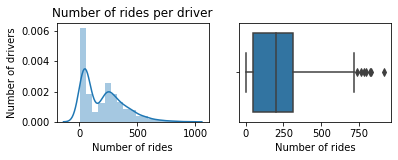

In [32]:
num_rides = ride_ids.groupby("driver_id").count()["ride_id"]

fig = plt.figure()
ax = fig.add_subplot(221)
sns.distplot(num_rides)

plt.title("Number of rides per driver")
plt.xlabel("Number of rides")
plt.ylabel("Number of drivers")

ax = fig.add_subplot(222)
sns.boxplot(num_rides)

plt.xlabel("Number of rides")


plt.show()

In [33]:
##Let's find the distribution of average distance/duration/primetime of each driver
avg_distance_duration = ride_ids.groupby("driver_id").agg(np.mean)
avg_distance_duration.head()

,ride_distance,ride_duration,ride_prime_time
driver_id,,,
002be0ffdc997bd5c50703158b7c2491,6282.624549,798.693141,19.404332
007f0389f9c7b03ef97098422f902e62,3791.322581,661.193548,20.161290
011e5c5dfc5c2c92501b8b24d47509bc,7930.970588,858.970588,19.852941
0152a2f305e71d26cc964f8d4411add9,7702.821990,913.722513,10.732984
01674381af7edd264113d4e6ed55ecda,8329.717333,953.181333,12.533333


**Average ride variable distribution**

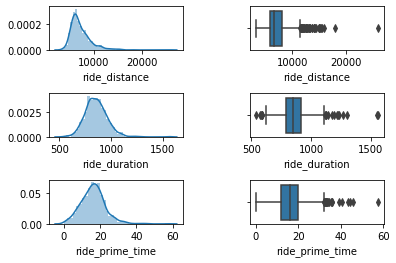

In [34]:

fig = plt.figure()
ax = fig.add_subplot(321)
sns.distplot(avg_distance_duration["ride_distance"])

ax = fig.add_subplot(322)
sns.boxplot(avg_distance_duration["ride_distance"])

ax = fig.add_subplot(323)
sns.distplot(avg_distance_duration["ride_duration"])

ax = fig.add_subplot(324)
sns.boxplot(avg_distance_duration["ride_duration"])

ax = fig.add_subplot(325)
sns.distplot(avg_distance_duration["ride_prime_time"])

ax = fig.add_subplot(326)
sns.boxplot(avg_distance_duration["ride_prime_time"])

fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.5)

plt.show()

**Adding miles/minutes to calculate total earnings per ride of driver**

In [69]:
ride_ids["ride_distance_miles"] = ride_ids["ride_distance"]*0.000621371
ride_ids["ride_duration_minutes"] = ride_ids["ride_duration"]/60
ride_ids["ride_fare"] = ride_ids["ride_distance_miles"]*1.15 + ride_ids["ride_duration_minutes"]*0.22 + 1.75 + 2
ride_ids.head(10)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_minutes,ride_fare
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,1.125303,5.450000,6.243098
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,2.089049,13.483333,9.118740
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,2.039340,9.533333,8.192574
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,40.564963,55.633333,62.639041
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,2.556942,13.716667,9.708150
5,002be0ffdc997bd5c50703158b7c2491,03d6b9d80b8a96135cb9b25178e9e203,4832,917,100,3.002465,15.283333,10.565168
6,002be0ffdc997bd5c50703158b7c2491,04053c0ed21761e07f0b869cab5b7dd0,1575,347,0,0.978659,5.783333,6.147792
7,002be0ffdc997bd5c50703158b7c2491,0534d432e0186625f623aaee57af98be,3056,687,25,1.898910,11.450000,8.452746
8,002be0ffdc997bd5c50703158b7c2491,053a1621c0affcd2b9c517af5c2bc843,3940,1143,75,2.448202,19.050000,10.756432
9,002be0ffdc997bd5c50703158b7c2491,066e92c52f59486de56cd7b8716a4ca6,3957,868,50,2.458765,14.466667,9.760246


In [72]:
#Filter out all the ride_fares that are less than $5 and greater than $400
ride_ids_filtered = ride_ids.query("ride_fare > 400 | ride_fare < 5")
ride_ids_filtered["driver_id"].value_counts()

3788dc9e91f1548816ce8b5af07ddadc    37
25827d13d5d988125ef4cc8a2ea3ddc1    27
e61357801b8cc7a4b40cf736e6890972    26
fd39748ba122e84e9ac492e6fb7c7a05    21
a7fa04a6b4111cac92989ac266ec40d2    19
af8cad352c24bda90b2a5d07e1049181    19
689bdf87fb2de49f98bf4946cfaa5068    18
a53de9ae055503d13bbcd6e19c5c311e    17
96d7ab03f9156154f6f2144263a85579    14
fe35f74209d1056dd315ddb17681203d    13
3a52faf7577b389cbe9912652cbad33c    13
de0746635475c2be3d26489184659460    12
cd970d2e7d3034e5946e71db0b4869c5    12
86a1dbd33d3ee6d68caa25966a2868a3    12
3c69563a9561f995598ed81f1f5c331a    11
9da29e218f6be3ea257d35f98eee1088    11
914712bea449e20e1cd2e18c269481bf    11
3af5c66b6800650cebac636822ac14c7    11
d0f374c7d36c93ba0772626d4c4e6f7a    10
1b51afba3b72e0259db160170f824f95    10
b6b8068eea005094bf1eeab9c35c9c11    10
1b9ddecea8eb99bc37f9b0711546f1c0    10
a69bbe711400a8eaf17206a9d2b4f26a    10
39a7bc235caf53556b15dd28ab5a7157    10
e38156350137c3a0df6b4b43c002ce0b     9
4eb382d1f7d50fae129496426

**Num rides outliers**

In [36]:
## We can use z-score to identify outliers. We will be using a threshold of 3. 
z_score_num_rides = sc.stats.zscore(num_rides)
num_rides_outliers = ride_ids.groupby("driver_id").count()[np.abs(z_score_num_rides) > 3]
num_rides_outliers

,ride_id,ride_distance,ride_duration,ride_prime_time
driver_id,,,,
19e1cdfeaf90239d8585e6a78136a403,737,737,737,737
3788dc9e91f1548816ce8b5af07ddadc,783,783,783,783
4eb382d1f7d50fae1294964263d1ce82,831,831,831,831
5ccc0e6dc9c7475caf785cdce7b8eb7a,919,919,919,919
689bdf87fb2de49f98bf4946cfaa5068,794,794,794,794
844e9be5a30d8d9c1f8e9ddb086ff717,821,821,821,821
af452fac966efa9d089953c99045bb20,761,761,761,761


In [48]:
num_rides_series = ride_ids["driver_id"].value_counts().to_frame().reset_index().rename(columns={"driver_id":"count", "index":"driver_id"})
num_rides_series.head()

,driver_id,count
0,5ccc0e6dc9c7475caf785cdce7b8eb7a,919
1,4eb382d1f7d50fae1294964263d1ce82,831
2,844e9be5a30d8d9c1f8e9ddb086ff717,821
3,689bdf87fb2de49f98bf4946cfaa5068,794
4,3788dc9e91f1548816ce8b5af07ddadc,783


**Ride Distance Outliers**

In [49]:
## Again use the z-score to identify outliers within the rides_id table. We will do ride_distance first.
z_score_ride_distance = sc.stats.zscore(avg_distance_duration["ride_distance"])
ride_distance_outliers = avg_distance_duration[np.abs(z_score_ride_distance) > 3].reset_index(level=0)
ride_distance_outliers

## Let's see if any of the missing drivers are outliers.

,driver_id,ride_distance,ride_duration,ride_prime_time
0,02d6a6b8a6da15fc219a9570f7ebbe78,25801.919355,1556.241935,3.629032
1,0f057c0c73054f569a59a0880b91cbb0,14220.250000,986.656250,5.468750
2,186d02f3ae489428440a352e3fe503a4,15084.562500,1232.562500,19.531250
3,22d43c4cd79a3cbab663d9eadd1e5995,15025.675603,1217.008043,25.134048
4,56bda1ed3f3299ff6e8465398a498a5b,13711.313725,1066.235294,2.941176
5,6455eac21c029b8d93ff09c2dffcea35,15837.405405,953.810811,17.567568
6,81a65fba6ab7fd7ffa6b18913dac83db,13959.212121,1045.462121,7.954545
7,915b7e1b8cdd0e1bf9826e8ae91706b4,13647.785714,1036.380952,7.738095
8,93fb5779620ce28dea9cb83cbb25ff9b,13995.651163,1095.441860,8.139535
9,9494350df132e6748afca3bc5d138dcc,14929.000000,1104.744186,6.976744


Let's find out more about the ride distance outliers. This will help us locate profiles. 

In [51]:
## Let's see the join date and the number of rides each driver has. There must be patterns. 
ride_distance_outliers_merged = pd.merge(ride_distance_outliers, driver_ids, how="left", on="driver_id")
ride_distance_outliers_merged = pd.merge(ride_distance_outliers, num_rides_series, how="left", on="driver_id")
ride_distance_outliers_merged

,driver_id,ride_distance,ride_duration,ride_prime_time,count
0,02d6a6b8a6da15fc219a9570f7ebbe78,25801.919355,1556.241935,3.629032,62
1,0f057c0c73054f569a59a0880b91cbb0,14220.250000,986.656250,5.468750,32
2,186d02f3ae489428440a352e3fe503a4,15084.562500,1232.562500,19.531250,32
3,22d43c4cd79a3cbab663d9eadd1e5995,15025.675603,1217.008043,25.134048,373
4,56bda1ed3f3299ff6e8465398a498a5b,13711.313725,1066.235294,2.941176,51
5,6455eac21c029b8d93ff09c2dffcea35,15837.405405,953.810811,17.567568,37
6,81a65fba6ab7fd7ffa6b18913dac83db,13959.212121,1045.462121,7.954545,132
7,915b7e1b8cdd0e1bf9826e8ae91706b4,13647.785714,1036.380952,7.738095,42
8,93fb5779620ce28dea9cb83cbb25ff9b,13995.651163,1095.441860,8.139535,43
9,9494350df132e6748afca3bc5d138dcc,14929.000000,1104.744186,6.976744,43


**Quick check to see if all drivers in driver_id are in ride_id**

In [93]:
print(driver_ids.shape[0])
print(ride_ids.groupby("driver_id").count().shape[0])

driver_ids.query("driver_id == '81a65fba6ab7fd7ffa6b18913dac83db'")
#ride_ids.query("driver_id == '81a65fba6ab7fd7ffa6b18913dac83db'")

## And back to cleaning data. LOL

937
937


,driver_id,driver_onboard_date


**Ride Duration Outliers**

In [58]:
## Again use the z-score to identify outliers within the rides_id table. We will do ride_duration.
z_score_ride_duration= sc.stats.zscore(avg_distance_duration["ride_duration"])
ride_duration_outliers = avg_distance_duration[np.abs(z_score_ride_duration) > 3].reset_index()
ride_duration_outliers

,driver_id,ride_distance,ride_duration,ride_prime_time
0,02d6a6b8a6da15fc219a9570f7ebbe78,25801.919355,1556.241935,3.629032
1,186d02f3ae489428440a352e3fe503a4,15084.562500,1232.562500,19.531250
2,1a2af09b492ba2519c5b4aec478642a7,12823.425197,1228.665354,15.452756
3,22d43c4cd79a3cbab663d9eadd1e5995,15025.675603,1217.008043,25.134048
4,3b6ae24dc593e6609bf90a1b80630439,10382.966102,1266.559322,7.627119
5,d9ef4b835e202c9b24315b999894362a,17994.000000,1558.208333,28.645833
6,e38156350137c3a0df6b4b43c002ce0b,14031.927273,1194.818182,10.727273
7,f467b8de5a37d9a818c0cbb557089c55,14984.241379,1299.551724,18.965517


Let's find out more about the ride duration outliers, (note this is including the 83 drivers with no start date).

In [59]:
ride_duration_outliers = pd.merge(ride_duration_outliers, num_rides_series, how="left", on="driver_id")
ride_duration_outliers

,driver_id,ride_distance,ride_duration,ride_prime_time,count
0,02d6a6b8a6da15fc219a9570f7ebbe78,25801.919355,1556.241935,3.629032,62
1,186d02f3ae489428440a352e3fe503a4,15084.562500,1232.562500,19.531250,32
2,1a2af09b492ba2519c5b4aec478642a7,12823.425197,1228.665354,15.452756,254
3,22d43c4cd79a3cbab663d9eadd1e5995,15025.675603,1217.008043,25.134048,373
4,3b6ae24dc593e6609bf90a1b80630439,10382.966102,1266.559322,7.627119,59
5,d9ef4b835e202c9b24315b999894362a,17994.000000,1558.208333,28.645833,48
6,e38156350137c3a0df6b4b43c002ce0b,14031.927273,1194.818182,10.727273,275
7,f467b8de5a37d9a818c0cbb557089c55,14984.241379,1299.551724,18.965517,29


**Ride Primetime Outliers**

In [60]:
## Again use the z-score to identify outliers within the rides_id table. We will do ride_duration.
z_score_ride_primetime= sc.stats.zscore(avg_distance_duration["ride_prime_time"])
ride_primetime_outliers = avg_distance_duration[np.abs(z_score_ride_primetime) > 3].reset_index()
ride_primetime_outliers

,driver_id,ride_distance,ride_duration,ride_prime_time
0,37ac4f9379c836b08c9a6e2315fd66af,4824.159091,827.363636,57.386364
1,6cb35e276085548f3f095a85aa63af7b,6563.928571,959.464286,45.535714
2,7419cd5c573ff9994c0f8ff5d92b4408,11851.507937,1050.253968,40.476190
3,7ad917215da937eefdf48e3c9d3fcf26,7021.768116,907.927536,44.444444
4,987c2e7dfc9a93697b8dfd030487ff01,5302.027523,826.021407,43.272171
5,dae249fc394c9bdf02f7d8bb1ff55733,9342.616667,857.383333,39.166667


In [62]:
ride_primetime_outliers_merged = pd.merge(ride_primetime_outliers, num_rides_series, how="left", on="driver_id")
ride_primetime_outliers_merged

,driver_id,ride_distance,ride_duration,ride_prime_time,count
0,37ac4f9379c836b08c9a6e2315fd66af,4824.159091,827.363636,57.386364,44
1,6cb35e276085548f3f095a85aa63af7b,6563.928571,959.464286,45.535714,28
2,7419cd5c573ff9994c0f8ff5d92b4408,11851.507937,1050.253968,40.476190,63
3,7ad917215da937eefdf48e3c9d3fcf26,7021.768116,907.927536,44.444444,207
4,987c2e7dfc9a93697b8dfd030487ff01,5302.027523,826.021407,43.272171,327
5,dae249fc394c9bdf02f7d8bb1ff55733,9342.616667,857.383333,39.166667,60
